In [1]:
from os import getcwd
from os.path import join, basename
from sys import path 

libs_dir = join("/".join(getcwd().split("/")[:-1]))
path.append(libs_dir)

filename = basename(globals()['__vsc_ipynb_file__']).split(".")[0]

import numpy as np
from libs.qchannel_model import *
import matplotlib.pyplot as plt
from libs.figure_config import *
from libs.default_parameters import *
from libs.simulation_tools import *
from qiskit_aer import AerSimulator

In [2]:
num_channel_coefficients = 1000 #100000
# num_qubits_per_execute = int(1000)
num_qubits_per_channel_coefficient = int(1e6)

# tau_zen_list = [0.91, 0.85, 0,75, 0.53]
tau_zen = 0.75
zenith_angle_deg_list = np.linspace(0, 60, 7)
# num_running = total_qubit/num_qubits

In [3]:
zenith_angle_deg_list

array([ 0., 10., 20., 30., 40., 50., 60.])

In [4]:
backend = AerSimulator()
user0 = User("Alice", None, None, None) 
user1 = User("Bob", None, None, None)

qber_values = np.zeros(len(zenith_angle_deg_list))

qber_theory = np.zeros(len(zenith_angle_deg_list))

In [5]:
for jdx in range(len(zenith_angle_deg_list)):
    zenith_angle_deg = zenith_angle_deg_list[jdx]
    
    zenith_angle_rad = np.radians(zenith_angle_deg)
    
    sigma_R_squared = rytov_variance(
        wavelength, zenith_angle_rad, h_OGS, h_atm, Cn2_profile)
    
    slant_distance = compute_slant_distance(h_s, h_OGS, zenith_angle_rad)
    
    w_L = slant_distance * theta_rad
    
    w_Leq_squared = equivalent_beam_width_squared(a, w_L)

    qber_theory[jdx], _ = compute_avg_qber(
        sigma_theta_x, sigma_theta_y, slant_distance, mu_x, mu_y,
        zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
        a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
    )
    print(
        qber_theory[jdx]
        # , avg_yield,
        # avg_err_bits, avg_err_bits/avg_yield
        )

    qber_record_per_sample = np.zeros(num_channel_coefficients)

    total_err_num = 0

    total_sifted_bit_length = 0

    for idx in range(num_channel_coefficients):
        eta_ell = compute_atm_loss(tau_zen, zenith_angle_rad)
        I_a = rvs_LN_fading(sigma_R_squared, size=1)
        eta_p = rvs_pointing_err(
            mu_x, mu_y, sigma_theta_x, sigma_theta_y,
            slant_distance, theta_rad, a, w_Leq_squared, size=1
            )
        
        insta_eta = eta_ell * I_a * eta_p
        insta_qber = qber_loss(
            e_0, p_dark, e_pol, p_AP, insta_eta, n_s
        )[0]

        insta_yield = compute_yield(
            insta_eta, n_s, p_dark, p_AP
        )[0]
        # print(insta_qber, insta_yield)
        num_detected_event = int(insta_yield * num_qubits_per_channel_coefficient)

        # for _ in range(int(num_running)):
        part_ka, part_kb, err_num = generate_Siftedkey(
            user0, user1, num_detected_event, insta_qber, backend
        )
        
        total_err_num += err_num
        total_sifted_bit_length += len(part_ka)
        # print(num_detected_event, len(part_ka), err_num)
            # print(err_num/len(part_ka), insta_qber)
        # if total_sifted_bit_length == 0:
        #     qber = 0
        # else:
        #     qber = total_err_num / total_sifted_bit_length

        # qber_record_per_sample[idx] = qber
    avg_qber = total_err_num/total_sifted_bit_length
    print(f'QBER: {avg_qber} at {zenith_angle_deg} deg',)
    qber_values[jdx] = avg_qber

0.060672566298624706
QBER: 0.06135381406488904 at 0.0 deg
0.06127798729306555
QBER: 0.06106395088339651 at 10.0 deg
0.06325568264714297
QBER: 0.06329414622953475 at 20.0 deg
0.06717959779318494
QBER: 0.06790551817431177 at 30.0 deg
0.07438125249136189
QBER: 0.07558945908460471 at 40.0 deg
0.0878193272089485
QBER: 0.09000697982401018 at 50.0 deg
0.11354163877892827
QBER: 0.12325518953619337 at 60.0 deg


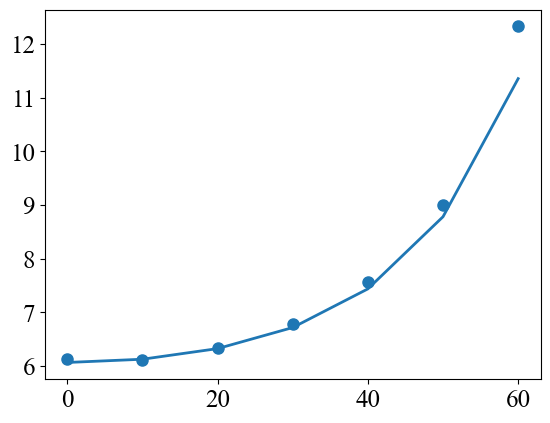

In [6]:
plt.scatter(zenith_angle_deg_list, qber_values*100)
plt.plot(zenith_angle_deg_list, qber_theory*100)